In [1]:
import notebook_settings  # type: ignore

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from tqdm.notebook import tqdm

from src.functional import correlation_for_all_neurons, sigmoid
from src.simulators import NetworkSystemSimulator
from src.utils import plot_neural_activity

In [3]:
def sigmoid(x: torch.Tensor) -> torch.Tensor:
    return 1 / (1 + (-x).exp())


class FlowModel(nn.Module):
    def __init__(self, n_neurons: int, num_hid: int):
        super().__init__()
        # Red neuronal de 1 capa densa
        self.mlp = nn.Sequential(
            nn.Linear(n_neurons * n_neurons, num_hid),
            nn.LeakyReLU(),
            nn.Linear(num_hid, 2),
        )

    def forward(self, x):
        y = self.mlp(x)
        F = sigmoid(y)
        return F

In [4]:
def reward_function(original: torch.Tensor, generated: torch.Tensor) -> torch.Tensor:
    diff = torch.nn.functional.mse_loss(generated, original)
    return 1 / (diff + 1)


def column_reward(matrix: torch.Tensor, std: float = 1.0) -> torch.Tensor:
    n_neurons = len(matrix)
    n_neurons_connected = matrix.sum(dim=0)
    reward = torch.exp(-(n_neurons_connected - 0.5 * n_neurons) / 2 * (std * std))
    return reward.sum()


def get_parents_flow_continuous(state: torch.Tensor, step: int) -> torch.Tensor:
    flow_list = []
    new_state = torch.zeros_like(state)
    for i in range(step):
        flow = state[i]
        flow_list.append(flow)
        new_state[i] = flow
    return torch.tensor(flow_list)


def get_parents_flow_binary(
    state: torch.Tensor, 
    step: int, 
    flow_function: nn.Module
) -> torch.Tensor:
    flow_list = []
    new_state = torch.zeros_like(state)
    for i in enumerate(step):
        index = state[i]
        flow_list.append(flow_function(new_state)[index.int()])
        new_state[i] = index
    return torch.tensor(flow_list)

In [6]:
# Configuración del problema
n_neurons = 3
timesteps = 5_000
F_sa = FlowModel(n_neurons, 512)
simulator = NetworkSystemSimulator()
simulations = torch.load("Id3x3.pt", weights_only=True)
A = torch.eye(n_neurons)

# Acumulación de métricas
losses = []
sampled_matrices = []
rewards = []
minibatch_loss = torch.tensor(0.0)

# Configuración entrenamiento
batch_size = 250
n_epochs = 50
opt = torch.optim.Adam(F_sa.parameters(), 0.001)

# Entrenamiento
pbar = tqdm(range(n_epochs))
for _ in pbar:
    for index in tqdm(range(0, len(simulations), batch_size), leave=False, position=1):
        batch = simulations[index : index + batch_size]
        for simulation in batch:
            # Para cada simulación la matriz comienza vacía
            state = torch.zeros(n_neurons * n_neurons)
            for t in range(n_neurons * n_neurons):
                # Se calcula F(s, a)
                edge_flow_prediction = F_sa(state)
                # Se calculan las probabilidades, que serían normalizar el flujo
                policy = edge_flow_prediction / edge_flow_prediction.sum()
                # Se escoge qué flujo colocar en la matriz
                action = Categorical(probs=policy).sample()
                # Se pasa al estado siguiente aplicando la acción
                new_state = state.clone()
                new_state[t] = edge_flow_prediction[action].detach()

                # Se calcula el flujo de los padres
                parent_edge_flow_preds = get_parents_flow_continuous(new_state, t+1)
                
                # Si es el último paso, se calcula la recompensa
                if t == (n_neurons * n_neurons - 1):
                    # Se usa el mismo punto inicial de la simulación actual
                    generated_timeseries = simulator.simulate_neurons(
                        new_state.reshape((n_neurons, n_neurons)),
                        timesteps,
                        simulation[:, 0],
                    )
                    reward = reward_function(simulation, generated_timeseries).detach()
                    rewards.append(reward.item())
                    # Como es el estado final, el estado no tiene hijos y su flujo es 0
                    edge_flow_prediction = torch.zeros(n_neurons * n_neurons)

                # Si no es el estado final, la recompensa es 0 y se calcula el flujo del estado
                else:
                    reward = torch.tensor(0.0,)
                    edge_flow_prediction = F_sa(new_state)
                
                # Se calcula la loss buscando que el flujo de los padres sea el del estado
                # más la recompensa (si es estado final)
                flow_mismatch = (parent_edge_flow_preds.sum() - edge_flow_prediction.sum() - reward).pow(2)
                minibatch_loss += flow_mismatch
                state = new_state

        # Después de procesar cada batch se aplica el paso backward
        losses.append(minibatch_loss.detach().item())
        minibatch_loss.backward()
        pbar.set_description(f"loss: {losses[-1]:.3f}")
        opt.step()
        opt.zero_grad()
        minibatch_loss = torch.tensor(0.0)
        sampled_matrices.append(state)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [13]:
losses[-10:]

[0.014414274133741856,
 0.00890118908137083,
 0.020469386130571365,
 0.02122335508465767,
 0.02497914992272854,
 0.008853903040289879,
 0.0494188591837883,
 0.035491544753313065,
 0.05602065473794937,
 0.0352986603975296]

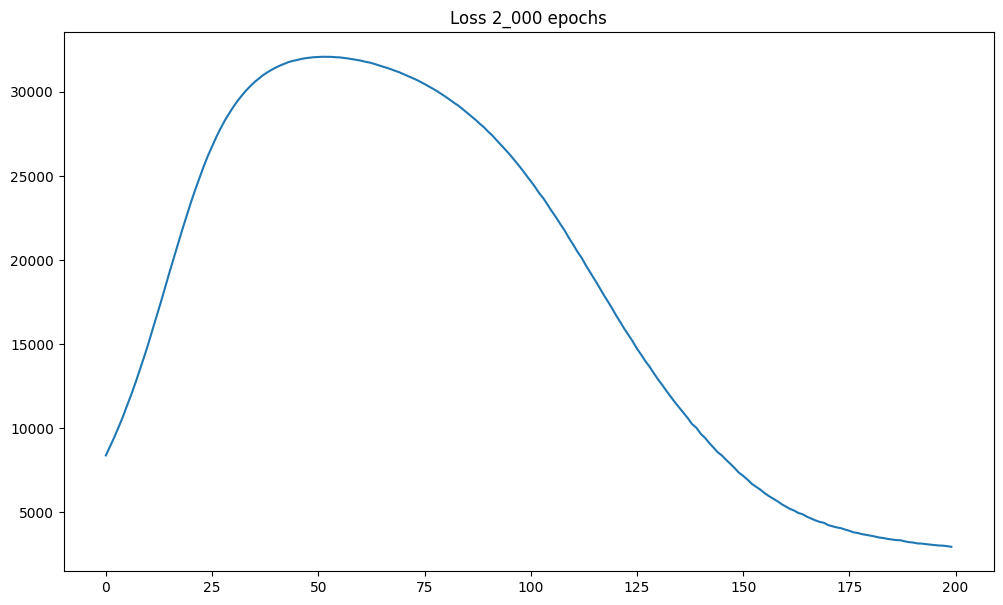

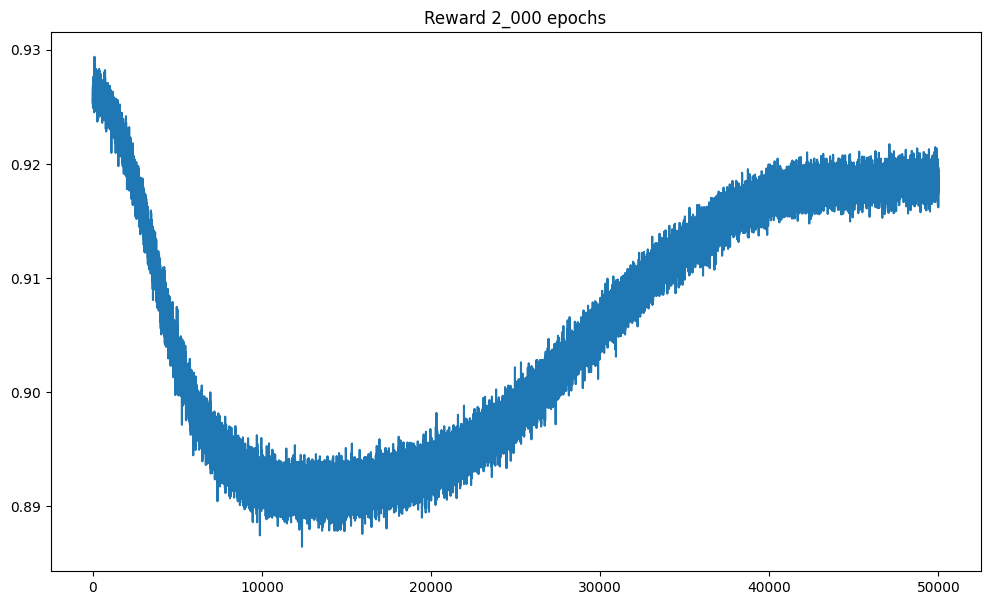

In [12]:
plt.figure(figsize=(12, 7))
plt.plot(losses)
plt.title(f"Loss {n_epochs:_} epochs")
plt.show()

plt.figure(figsize=(12, 7))
plt.plot(rewards)
plt.title(f"Reward {n_epochs:_} epochs")
plt.show()

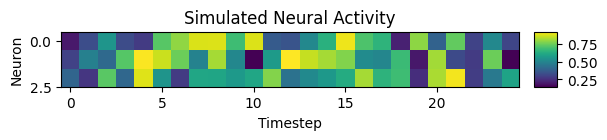

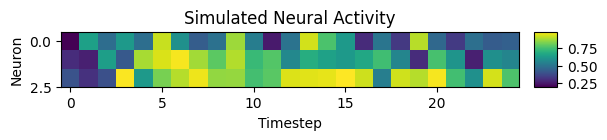

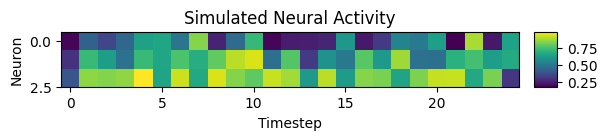

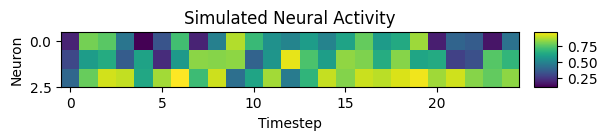

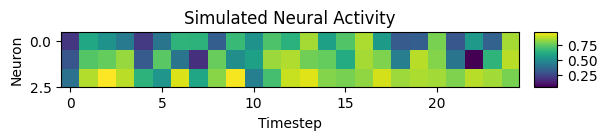

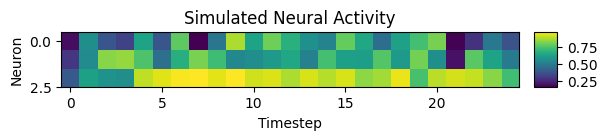

In [13]:
plot_neural_activity(
    simulator.simulate_neurons(
        torch.eye(n_neurons), timesteps, torch.tensor([0.2, 0.3, 0.4])
    ),
    25,
)
for matrix in sampled_matrices[-5:]:
    plot_neural_activity(
        simulator.simulate_neurons(
            matrix.reshape((n_neurons, n_neurons)),
            timesteps,
            torch.tensor([0.2, 0.3, 0.4]),
        ),
        25,
    )

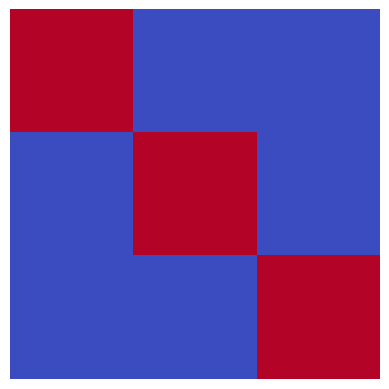

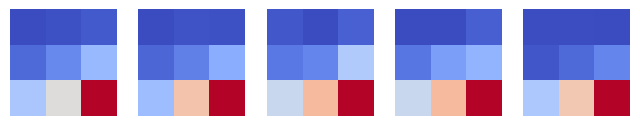

In [19]:
A = torch.eye(n_neurons)
plt.imshow(A, cmap="coolwarm")
plt.axis("off")
f, ax = plt.subplots(1, 5, figsize=(8, 8))
for i, face in enumerate(sampled_matrices[-5:]):
    plt.sca(ax[i % 5])
    plt.imshow(face.reshape(n_neurons, n_neurons), cmap="coolwarm")
    plt.axis("off")